In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

1.Load Data

In [34]:
df=pd.read_csv(r"C:\Users\Aanjney\Desktop\Deploy\Covid-19\data\covid19_global_statistics_2026.csv")
df.head()

,continent,country,population,date,new_cases,active_cases,cases_per_million,total_cases,new_deaths,deaths_per_million,total_deaths,tests_per_million,total_tests
0,Africa,Eritrea,3662244.0,2026-02-16,NaN,0.0,2782.0,10189,NaN,28.0,103.0,6470.0,23693.0
1,Africa,Niger,26083660.0,2026-02-16,NaN,729.0,381.0,9931,NaN,12.0,312.0,9759.0,254538.0
2,Africa,Saint-Helena,6115.0,2026-02-16,NaN,2164.0,354211.0,2166,NaN,NaN,NaN,NaN,NaN
3,South-America,Falkland-Islands,3539.0,2026-02-16,NaN,0.0,545352.0,1930,NaN,NaN,NaN,2439107.0,8632.0
4,North-America,Montserrat,4965.0,2026-02-16,NaN,19.0,282578.0,1403,NaN,1611.0,8.0,3577442.0,17762.0


2.Basic Cleaning

In [35]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

3.Drop duplicates

In [36]:
df.drop_duplicates(inplace=True)

4.Remove unnecessary whitespace

In [37]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

5.Fill Missing Values

In [38]:
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)

for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

6. EDA

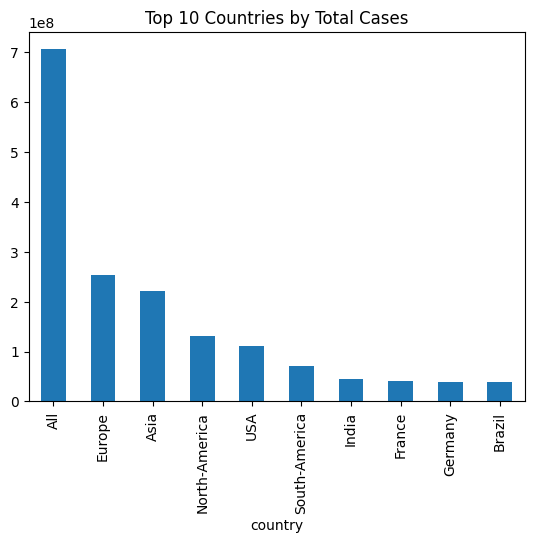

In [39]:
plt.figure()
df.groupby("country")["total_cases"].sum().sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Top 10 Countries by Total Cases")
plt.savefig("top10_cases.png")

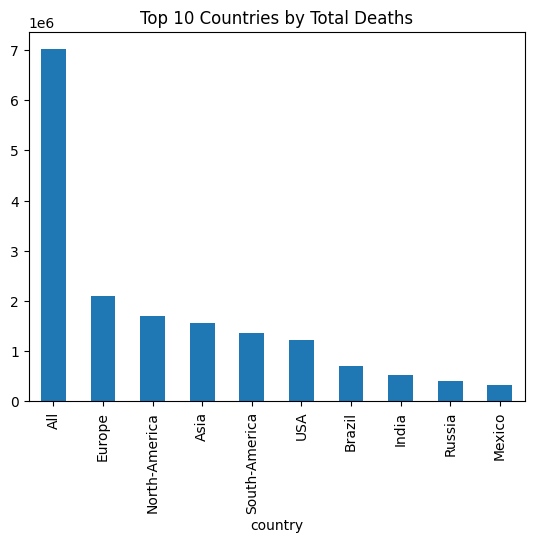

In [40]:
plt.figure()
df.groupby("country")["total_deaths"].sum().sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Top 10 Countries by Total Deaths")
plt.savefig("top10_deaths.png")

7.Target Variable

In [41]:
target = "total_deaths"

X = df.drop(columns=[target])
y = df[target]

8.Identify categorical & numerical columns

In [42]:
num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(include='object').columns

9.Preprocessing Pipeline

In [43]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder',  LabelEncoder())
])

10.Manual encoding

In [44]:
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols)
])

11.Train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

12. Regression Models

In [46]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoost": GradientBoostingRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "XGBoost": XGBRegressor()
}

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    results[name] = {
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    }

13.Convert result to Dataframe

In [47]:
results_df = pd.DataFrame(results).T.sort_values(by="R2", ascending=False)
print(results_df)


                     R2            MAE           RMSE
GradientBoost  0.738877   38329.323997  148674.229530
XGBoost        0.688143   39536.132699  162476.565244
KNN            0.659714   47842.600000  169720.782574
RandomForest   0.593626   47753.013125  185470.954756
Linear         0.513989   57601.733623  202831.739350
Lasso          0.513890   57604.586268  202852.588974
Ridge          0.455174   59454.689185  214754.385149
SVR           -0.062280   74341.590031  299869.754087
DecisionTree  -6.670807  154398.125000  805811.747099


14.Saving Best Model

In [48]:
best_model_name = results_df.index[0]
best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', models[best_model_name])
])

best_model.fit(X, y)

os.makedirs("model", exist_ok=True)
joblib.dump(best_model, "model/best_model.pkl")

print(f"Best Model Saved: {best_model_name}")

Best Model Saved: GradientBoost
